In [1]:
import sys
import os

#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# LinearRegression class with MSE as the error function

from modules.LinearRegression import LinearRegression 
lr_mse = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mse')
lr_mse.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr_mse.fit()

Epoch 1/1000, Loss: 2.418777752991966
Epoch 101/1000, Loss: 0.5590408037745176
Epoch 201/1000, Loss: 0.538913527766438
Epoch 301/1000, Loss: 0.5321539565549764
Epoch 401/1000, Loss: 0.5287653287370756
Epoch 501/1000, Loss: 0.5267319973832091
Epoch 601/1000, Loss: 0.5253743404785142
Epoch 701/1000, Loss: 0.5244041018366664
Epoch 801/1000, Loss: 0.5236763682313382
Epoch 901/1000, Loss: 0.5231098212397084


In [5]:
overall_loss, y_preds = lr_mse.evaluate(X_test_scaled, y_test.reshape(-1, 1), loss_function='mse', pred=True)

array([[0.71019326],
       [1.75980369],
       [2.70454536],
       ...,
       [4.4798368 ],
       [1.18283757],
       [2.00100979]])

In [12]:
# LinearRegression class with MAE as the error function
lr_mae = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mae')
lr_mae.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr_mae.fit()

Epoch 1/1000, Loss: 1.7144681733049973
Epoch 101/1000, Loss: 0.5659000969996969
Epoch 201/1000, Loss: 0.5390221446210968
Epoch 301/1000, Loss: 0.5298848568443344
Epoch 401/1000, Loss: 0.5252627451338465
Epoch 501/1000, Loss: 0.5224724294992559
Epoch 601/1000, Loss: 0.520605418630518
Epoch 701/1000, Loss: 0.5192687265272586
Epoch 801/1000, Loss: 0.5182652703185343
Epoch 901/1000, Loss: 0.517484082313216


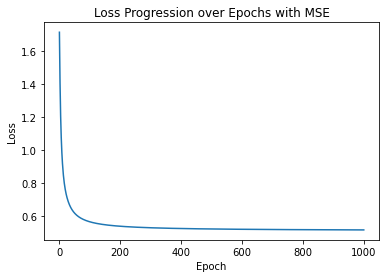

In [13]:

import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr_mse.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs with MSE')
plt.show()


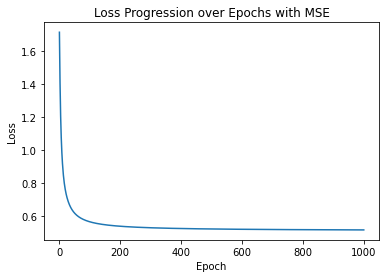

In [14]:
import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr_mae.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs with MSE')
plt.show()


In [16]:
lr_mse.evaluate(X_test_scaled, y_test.reshape(-1, 1)) 

0.5615038146545815

In [15]:
lr_mae.evaluate(X_test_scaled, y_test.reshape(-1, 1))

0.5119924202555431

In [ ]:
lr_mse._r2(y_test.reshape(-1, 1), )